In [25]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

In [26]:
MACHINE_LOCAL = False

In [27]:
url = 'https://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None
if MACHINE_LOCAL:
    data_root = '/Users/yangbo/working/机器学习/深度学习/作业/NLP/NLP/assignment-09/res/' # Change me to store data elsewhere
else:
    data_root = '/data/zz/nlp/l9/res/'

In [28]:

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 5% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  dest_filename = os.path.join(data_root, filename)
  if force or not os.path.exists(dest_filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, dest_filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(dest_filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', dest_filename)
  else:
    raise Exception(
      'Failed to verify ' + dest_filename + '. Can you get to it with a browser?')
  return dest_filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Found and verified /data/zz/nlp/l9/res/notMNIST_large.tar.gz
Found and verified /data/zz/nlp/l9/res/notMNIST_small.tar.gz


In [29]:

train_filename = data_root +'notMNIST_large.tar.gz'
test_filename = data_root + 'notMNIST_small.tar.gz'


In [30]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall(data_root)
    tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
  print(data_folders)
  return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

Extracting data for /data/zz/nlp/l9/res/notMNIST_large. This may take a while. Please wait.
['/data/zz/nlp/l9/res/notMNIST_large/A', '/data/zz/nlp/l9/res/notMNIST_large/B', '/data/zz/nlp/l9/res/notMNIST_large/C', '/data/zz/nlp/l9/res/notMNIST_large/D', '/data/zz/nlp/l9/res/notMNIST_large/E', '/data/zz/nlp/l9/res/notMNIST_large/F', '/data/zz/nlp/l9/res/notMNIST_large/G', '/data/zz/nlp/l9/res/notMNIST_large/H', '/data/zz/nlp/l9/res/notMNIST_large/I', '/data/zz/nlp/l9/res/notMNIST_large/J']
Extracting data for /data/zz/nlp/l9/res/notMNIST_small. This may take a while. Please wait.
['/data/zz/nlp/l9/res/notMNIST_small/A', '/data/zz/nlp/l9/res/notMNIST_small/B', '/data/zz/nlp/l9/res/notMNIST_small/C', '/data/zz/nlp/l9/res/notMNIST_small/D', '/data/zz/nlp/l9/res/notMNIST_small/E', '/data/zz/nlp/l9/res/notMNIST_small/F', '/data/zz/nlp/l9/res/notMNIST_small/G', '/data/zz/nlp/l9/res/notMNIST_small/H', '/data/zz/nlp/l9/res/notMNIST_small/I', '/data/zz/nlp/l9/res/notMNIST_small/J']


In [31]:
train_folders
test_folders

['/data/zz/nlp/l9/res/notMNIST_small/A',
 '/data/zz/nlp/l9/res/notMNIST_small/B',
 '/data/zz/nlp/l9/res/notMNIST_small/C',
 '/data/zz/nlp/l9/res/notMNIST_small/D',
 '/data/zz/nlp/l9/res/notMNIST_small/E',
 '/data/zz/nlp/l9/res/notMNIST_small/F',
 '/data/zz/nlp/l9/res/notMNIST_small/G',
 '/data/zz/nlp/l9/res/notMNIST_small/H',
 '/data/zz/nlp/l9/res/notMNIST_small/I',
 '/data/zz/nlp/l9/res/notMNIST_small/J']

In [32]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
  """Load the data for a single letter label."""
  image_files = os.listdir(folder)
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
  print(folder)
  num_images = 0
  for image in image_files:
    image_file = os.path.join(folder, image)
    try:
      image_data = (imageio.imread(image_file).astype(float) - 
                    pixel_depth / 2) / pixel_depth
      if image_data.shape != (image_size, image_size):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      dataset[num_images, :, :] = image_data
      num_images = num_images + 1
    except (IOError, ValueError) as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
  dataset = dataset[0:num_images, :, :]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
    
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return dataset
        
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
  dataset_names = []
  for folder in data_folders:
    set_filename = folder + '.pickle'
    dataset_names.append(set_filename)
    if os.path.exists(set_filename) and not force:
      # You may override by setting force=True.
      print('%s already present - Skipping pickling.' % set_filename)
    else:
      print('Pickling %s.' % set_filename)
      dataset = load_letter(folder, min_num_images_per_class)
      try:
        with open(set_filename, 'wb') as f:
          pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
      except Exception as e:
        print('Unable to save data to', set_filename, ':', e)
  
  return dataset_names

train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)

Pickling /data/zz/nlp/l9/res/notMNIST_large/A.pickle.
/data/zz/nlp/l9/res/notMNIST_large/A
Could not read: /data/zz/nlp/l9/res/notMNIST_large/A/Um9tYW5hIEJvbGQucGZi.png : Could not find a format to read the specified file in mode 'i' - it's ok, skipping.
Could not read: /data/zz/nlp/l9/res/notMNIST_large/A/SG90IE11c3RhcmQgQlROIFBvc3Rlci50dGY=.png : Could not find a format to read the specified file in mode 'i' - it's ok, skipping.
Could not read: /data/zz/nlp/l9/res/notMNIST_large/A/RnJlaWdodERpc3BCb29rSXRhbGljLnR0Zg==.png : Could not find a format to read the specified file in mode 'i' - it's ok, skipping.
Full dataset tensor: (52909, 28, 28)
Mean: -0.1282502
Standard deviation: 0.44312108
Pickling /data/zz/nlp/l9/res/notMNIST_large/B.pickle.
/data/zz/nlp/l9/res/notMNIST_large/B
Could not read: /data/zz/nlp/l9/res/notMNIST_large/B/TmlraXNFRi1TZW1pQm9sZEl0YWxpYy5vdGY=.png : Could not find a format to read the specified file in mode 'i' - it's ok, skipping.
Full dataset tensor: (52911, 

## Problem 2

In [33]:
train_datasets

['/data/zz/nlp/l9/res/notMNIST_large/A.pickle',
 '/data/zz/nlp/l9/res/notMNIST_large/B.pickle',
 '/data/zz/nlp/l9/res/notMNIST_large/C.pickle',
 '/data/zz/nlp/l9/res/notMNIST_large/D.pickle',
 '/data/zz/nlp/l9/res/notMNIST_large/E.pickle',
 '/data/zz/nlp/l9/res/notMNIST_large/F.pickle',
 '/data/zz/nlp/l9/res/notMNIST_large/G.pickle',
 '/data/zz/nlp/l9/res/notMNIST_large/H.pickle',
 '/data/zz/nlp/l9/res/notMNIST_large/I.pickle',
 '/data/zz/nlp/l9/res/notMNIST_large/J.pickle']

In [34]:
file_name_pickle = data_root + 'notMNIST_large/A.pickle'
try:
    with open(file_name_pickle, 'rb') as f:
        data_pickle_a = pickle.load(f)
        
except Exception as e:
    print('Unable to open data to', file_name_pickle, ':', e)


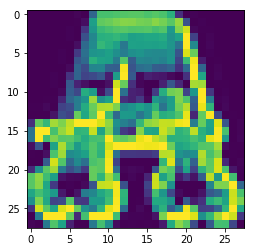

In [35]:
data_pickle_a[1,:,:]
plt.imshow(data_pickle_a[100,:,:])

In [36]:
file_name_pickle

'/data/zz/nlp/l9/res/notMNIST_large/A.pickle'

In [37]:
test_datasets

['/data/zz/nlp/l9/res/notMNIST_small/A.pickle',
 '/data/zz/nlp/l9/res/notMNIST_small/B.pickle',
 '/data/zz/nlp/l9/res/notMNIST_small/C.pickle',
 '/data/zz/nlp/l9/res/notMNIST_small/D.pickle',
 '/data/zz/nlp/l9/res/notMNIST_small/E.pickle',
 '/data/zz/nlp/l9/res/notMNIST_small/F.pickle',
 '/data/zz/nlp/l9/res/notMNIST_small/G.pickle',
 '/data/zz/nlp/l9/res/notMNIST_small/H.pickle',
 '/data/zz/nlp/l9/res/notMNIST_small/I.pickle',
 '/data/zz/nlp/l9/res/notMNIST_small/J.pickle']

In [40]:
file_name_pickle = data_root + 'notMNIST_small/A.pickle'
try:
    with open(file_name_pickle, 'rb') as f:
        data_small_a = pickle.load(f)        
except Exception as e:
    print('Unable to open data to', file_name_pickle, ':', e)


In [39]:
file_name_pickle

'/data/zz/nlp/l9/res/notMNIST_small/A.pickle'

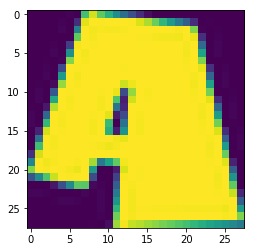

In [41]:
plt.imshow(data_small_a[60,:,:])

## Problem 3

In [42]:
def make_arrays(nb_rows, img_size):
  if nb_rows:
    dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
    labels = np.ndarray(nb_rows, dtype=np.int32)
  else:
    dataset, labels = None, None
  return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
  num_classes = len(pickle_files)
  valid_dataset, valid_labels = make_arrays(valid_size, image_size)
  train_dataset, train_labels = make_arrays(train_size, image_size)
  vsize_per_class = valid_size // num_classes
  tsize_per_class = train_size // num_classes
    
  start_v, start_t = 0, 0
  end_v, end_t = vsize_per_class, tsize_per_class
  end_l = vsize_per_class+tsize_per_class
  for label, pickle_file in enumerate(pickle_files):       
    try:
      with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f)
        # let's shuffle the letters to have random validation and training set
        np.random.shuffle(letter_set)
        if valid_dataset is not None:
          valid_letter = letter_set[:vsize_per_class, :, :]
          valid_dataset[start_v:end_v, :, :] = valid_letter
          valid_labels[start_v:end_v] = label
          start_v += vsize_per_class
          end_v += vsize_per_class
                    
        train_letter = letter_set[vsize_per_class:end_l, :, :]
        train_dataset[start_t:end_t, :, :] = train_letter
        train_labels[start_t:end_t] = label
        start_t += tsize_per_class
        end_t += tsize_per_class
    except Exception as e:
      print('Unable to process data from', pickle_file, ':', e)
      raise
    
  return valid_dataset, valid_labels, train_dataset, train_labels
            
            
train_size = 200000
valid_size = 10000
test_size = 10000

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
  train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (200000, 28, 28) (200000,)
Validation: (10000, 28, 28) (10000,)
Testing: (10000, 28, 28) (10000,)


In [43]:
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

In [44]:
print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (200000, 28, 28) (200000,)
Validation: (10000, 28, 28) (10000,)
Testing: (10000, 28, 28) (10000,)


## Problem 4

In [45]:
data_root

'/data/zz/nlp/l9/res/'

In [46]:
pickle_file = os.path.join(data_root, 'notMNIST.pickle')

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [47]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 690800506


## Problem 5

## Problem 6  逻辑回归训练

In [48]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
clr = LogisticRegression(penalty = 'l2',solver='saga', verbose=1)

### 1、Full train dataset

In [50]:
clr.fit(train_dataset.reshape((-1, 28*28)), train_labels)

/usr/local/Python36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 198 seconds


/usr/local/Python36/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


max_iter reached after 198 seconds
max_iter reached after 198 seconds
max_iter reached after 343 seconds
max_iter reached after 198 seconds
max_iter reached after 197 seconds
max_iter reached after 199 seconds
max_iter reached after 198 seconds
max_iter reached after 197 seconds
max_iter reached after 199 seconds


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 35.4min finished


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='saga', tol=0.0001, verbose=1,
                   warm_start=False)

In [51]:
y_predict = clr.predict(test_dataset.reshape((-1, 28*28)))

In [53]:
probility = clr.predict_proba(test_dataset.reshape((-1, 28*28)))           #计算各测试样本基于概率的预测 

In [54]:
score = clr.score(test_dataset.reshape((-1, 28*28)),test_labels,sample_weight=None)    #调用该对象的打分方法，计算出准确率

In [56]:
print('Accuracy:', score)

Accuracy: 0.892


### 2、100 train dataset

In [68]:
max_index = 100
clr.fit(train_dataset[:max_index].reshape((-1, 28*28)), train_labels[:max_index])
y_predict = clr.predict(test_dataset[:max_index].reshape((-1, 28*28)))
probility = clr.predict_proba(test_dataset[:max_index].reshape((-1, 28*28)))           #计算各测试样本基于概率的预测 
score = clr.score(test_dataset[:max_index].reshape((-1, 28*28)),test_labels[:max_index],sample_weight=None)    #调用该对象的打分方法，计算出准确率
print('Accuracy:', score)

/usr/local/Python36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/Python36/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


max_iter reached after 1 seconds
max_iter reached after 0 seconds
max_iter reached after 0 seconds
max_iter reached after 0 seconds
max_iter reached after 0 seconds
max_iter reached after 0 seconds
max_iter reached after 0 seconds
max_iter reached after 0 seconds
max_iter reached after 0 seconds
max_iter reached after 0 seconds
Accuracy: 0.67


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.9s finished


### 3、1000 train dataset

In [69]:
max_index = 1000
clr.fit(train_dataset[:max_index].reshape((-1, 28*28)), train_labels[:max_index])
y_predict = clr.predict(test_dataset[:max_index].reshape((-1, 28*28)))
probility = clr.predict_proba(test_dataset[:max_index].reshape((-1, 28*28)))           #计算各测试样本基于概率的预测 
score = clr.score(test_dataset[:max_index].reshape((-1, 28*28)),test_labels[:max_index],sample_weight=None)    #调用该对象的打分方法，计算出准确率
print('Accuracy:', score)

/usr/local/Python36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds


/usr/local/Python36/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


max_iter reached after 1 seconds
max_iter reached after 1 seconds
max_iter reached after 1 seconds
max_iter reached after 1 seconds
max_iter reached after 0 seconds
max_iter reached after 1 seconds
max_iter reached after 1 seconds
max_iter reached after 1 seconds
max_iter reached after 1 seconds
Accuracy: 0.82


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    9.1s finished


### 4、5000 train dataset

In [67]:
max_index = 5000
clr.fit(train_dataset[:max_index].reshape((-1, 28*28)), train_labels[:max_index])
y_predict = clr.predict(test_dataset[:max_index].reshape((-1, 28*28)))
probility = clr.predict_proba(test_dataset[:max_index].reshape((-1, 28*28)))           #计算各测试样本基于概率的预测 
score = clr.score(test_dataset[:max_index].reshape((-1, 28*28)),test_labels[:max_index],sample_weight=None)    #调用该对象的打分方法，计算出准确率
print('Accuracy:', score)

/usr/local/Python36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 5 seconds


/usr/local/Python36/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


max_iter reached after 4 seconds
max_iter reached after 5 seconds
max_iter reached after 4 seconds
max_iter reached after 5 seconds
max_iter reached after 4 seconds
max_iter reached after 5 seconds
max_iter reached after 4 seconds
max_iter reached after 5 seconds
max_iter reached after 5 seconds
Accuracy: 0.853


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   45.6s finished
